In [1]:
!pip install optuna 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from pytz import timezone
from datetime import datetime, timedelta
import json
import itertools
from tqdm import tqdm
import os
os.chdir("/content/drive/MyDrive/projects/table_stan")
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_log_error, mean_squared_error, mean_absolute_error
from sklearn.model_selection import KFold, train_test_split
import optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.3/365.3 KB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 KB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 KB 5.6 MB/s eta 0:00:00


In [2]:
data = pd.read_csv("data/train.csv")
X_sub = pd.read_csv("data/test.csv")
df_sub = pd.DataFrame({"id":np.arange(len(X_sub))})

In [3]:
target = "cost"
random_state = 13
test_size = 0.1
n_splits = 5
num_boost_round = 1000
stopping_rounds = 50
n_trials = 10
drop_columns = ["cost"]

X_train, X_test, y_train, y_test = train_test_split(data.drop(target, axis=1), data[target], test_size=test_size, random_state=random_state)
df_train = pd.DataFrame(pd.concat([X_train, y_train], axis=1), columns=data.columns)
df_test = pd.DataFrame(pd.concat([X_test, y_test], axis=1), columns=data.columns)

In [4]:
display(df_train.head())
display(df_test.head())

,store_sales(in millions),unit_sales(in millions),total_children,num_children_at_home,avg_cars_at home(approx).1,gross_weight,recyclable_package,low_fat,units_per_case,store_sqft,coffee_bar,video_store,salad_bar,prepared_food,florist,cost
26554,8.50,5.0,3.0,1.0,3.0,11.20,1.0,0.0,28.0,23598.0,0.0,0.0,0.0,0.0,1.0,101.84
37713,1.80,3.0,1.0,0.0,2.0,19.90,1.0,0.0,24.0,23759.0,1.0,0.0,1.0,1.0,1.0,89.90
32430,7.28,4.0,4.0,0.0,1.0,12.50,1.0,0.0,34.0,23759.0,1.0,0.0,1.0,1.0,1.0,89.90
28301,4.26,3.0,3.0,3.0,3.0,7.31,1.0,1.0,8.0,33858.0,1.0,0.0,1.0,1.0,1.0,136.74
1611,3.33,3.0,5.0,0.0,1.0,17.30,1.0,1.0,6.0,21215.0,1.0,0.0,0.0,0.0,0.0,135.80


,store_sales(in millions),unit_sales(in millions),total_children,num_children_at_home,avg_cars_at home(approx).1,gross_weight,recyclable_package,low_fat,units_per_case,store_sqft,coffee_bar,video_store,salad_bar,prepared_food,florist,cost
30798,5.13,3.0,3.0,2.0,3.0,20.90,0.0,1.0,23.0,21215.0,1.0,0.0,0.0,0.0,0.0,123.88
44160,4.44,3.0,2.0,2.0,2.0,14.00,0.0,0.0,34.0,23598.0,0.0,0.0,0.0,0.0,1.0,122.51
25844,8.73,3.0,2.0,0.0,2.0,21.80,1.0,0.0,10.0,30797.0,1.0,1.0,1.0,1.0,1.0,76.88
48597,8.88,3.0,5.0,2.0,2.0,9.96,0.0,1.0,32.0,30584.0,1.0,1.0,1.0,1.0,1.0,86.79
10109,6.39,3.0,5.0,1.0,3.0,17.00,0.0,0.0,35.0,30268.0,0.0,0.0,0.0,0.0,0.0,98.52


In [11]:
def objective(trial):
  param = {
        "random_state": random_state,
        "n_jobs": -1,
        "max_features": trial.suggest_float("max_features", 0.5, 1.0),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 0, 300),
        "bootstrap": trial.suggest_categorical("bootstrap", [True, False]),
        "n_estimators": trial.suggest_int("n_estimators", 2, 1000),
        "max_depth": trial.suggest_int("max_depth", 2, 9),
    }
  score = []
  for train_index, val_index in cv.split(df_train):
    y_train = np.log1p(df_train.iloc[train_index][target].to_numpy())
    X_train = df_train.drop(drop_columns, axis=1).iloc[train_index].to_numpy()
    y_val = df_train.iloc[val_index][target].to_numpy()
    X_val = df_train.drop(drop_columns, axis=1).iloc[val_index].to_numpy()
    
    # モデルを訓練する
    model = RandomForestRegressor(**param)
    model.fit(X_train, y_train)
    y_pred = np.expm1(model.predict(X_val))
    score.append(mean_squared_error(y_val, y_pred, squared=False))
  return -np.mean(score)


In [12]:
cv = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
evals_results = []

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=n_trials)

best_params = study.best_trial.params
best_score = study.best_trial.value

[I 2023-03-26 10:01:07,994] A new study created in memory with name: no-name-d223d383-1a0c-493a-abf2-5a160167f562
[I 2023-03-26 10:02:41,740] Trial 0 finished with value: -29.7696255772786 and parameters: {'max_features': 0.7521634092765404, 'min_samples_leaf': 112, 'bootstrap': True, 'n_estimators': 930, 'max_depth': 3}. Best is trial 0 with value: -29.7696255772786.
[I 2023-03-26 10:04:52,267] Trial 1 finished with value: -29.618963379655224 and parameters: {'max_features': 0.8357946158353009, 'min_samples_leaf': 268, 'bootstrap': True, 'n_estimators': 810, 'max_depth': 4}. Best is trial 1 with value: -29.618963379655224.
[I 2023-03-26 10:05:53,647] Trial 2 finished with value: -29.517499569788395 and parameters: {'max_features': 0.7686936700349929, 'min_samples_leaf': 173, 'bootstrap': True, 'n_estimators': 207, 'max_depth': 8}. Best is trial 2 with value: -29.517499569788395.
[I 2023-03-26 10:06:48,474] Trial 3 finished with value: -29.553755041320414 and parameters: {'max_features

In [14]:
base_params = {
    "random_state": random_state,
    "n_jobs": -1,
}

params = {**base_params, **study.best_trial.params}
print(params)
print(best_score)

{'random_state': 13, 'n_jobs': -1, 'max_features': 0.603813888215866, 'min_samples_leaf': 37, 'bootstrap': True, 'n_estimators': 961, 'max_depth': 9}
-29.467151626899486


In [21]:
cv = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
models = []
evals_results = []
FEATURES = df_train.drop(drop_columns, axis=1).columns.tolist()
df_importance = pd.DataFrame(index=FEATURES)
df_preds = df_sub[["id"]].copy()

scores = []

for i, (train_index, val_index) in enumerate(cv.split(df_train)):
  print("=" * 20, f"START FOLD {i+1}", "=" * 20)
  y_train = np.log1p(df_train.iloc[train_index][target].to_numpy())
  X_train = df_train.drop(drop_columns, axis=1).iloc[train_index].to_numpy()
  y_val = df_train.iloc[val_index][target].to_numpy()
  X_val = df_train.drop(drop_columns, axis=1).iloc[val_index].to_numpy()

  # 学習
  model = RandomForestRegressor(**params)
  model.fit(X_train, y_train)
  models.append(model)
  # 特徴量重要度
  df_importance[f"FOLD_{i+1}"] = model.feature_importances_
  # 検証データ
  y_pred = np.expm1(model.predict(X_val))
  rmsle = mean_squared_log_error(y_val, y_pred, squared=False)
  scores.append(rmsle)
  # 提出用データ
  pred = np.expm1(model.predict(X_sub))
  df_preds[f"pred_{i+1}"] = pred

==================== START FOLD 1 ====================


/usr/local/lib/python3.9/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


==================== START FOLD 2 ====================


/usr/local/lib/python3.9/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


==================== START FOLD 3 ====================


/usr/local/lib/python3.9/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


==================== START FOLD 4 ====================


/usr/local/lib/python3.9/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


==================== START FOLD 5 ====================


/usr/local/lib/python3.9/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


In [23]:
print(f"Score mean: {np.mean(scores)}, Fold scores: {scores}")

Score mean: 0.3081831972228416, Fold scores: [0.3076706057412675, 0.30961866597376914, 0.3085370584808357, 0.3087016531410789, 0.3063880027772565]


In [24]:
df_preds[target] = df_preds.drop("id", axis=1).mean(axis=1)
print(df_train[target].min(), df_train[target].max())
print(df_preds[target].min(), df_preds[target].max())

50.79 149.75
74.52387336367966 126.65317126181606


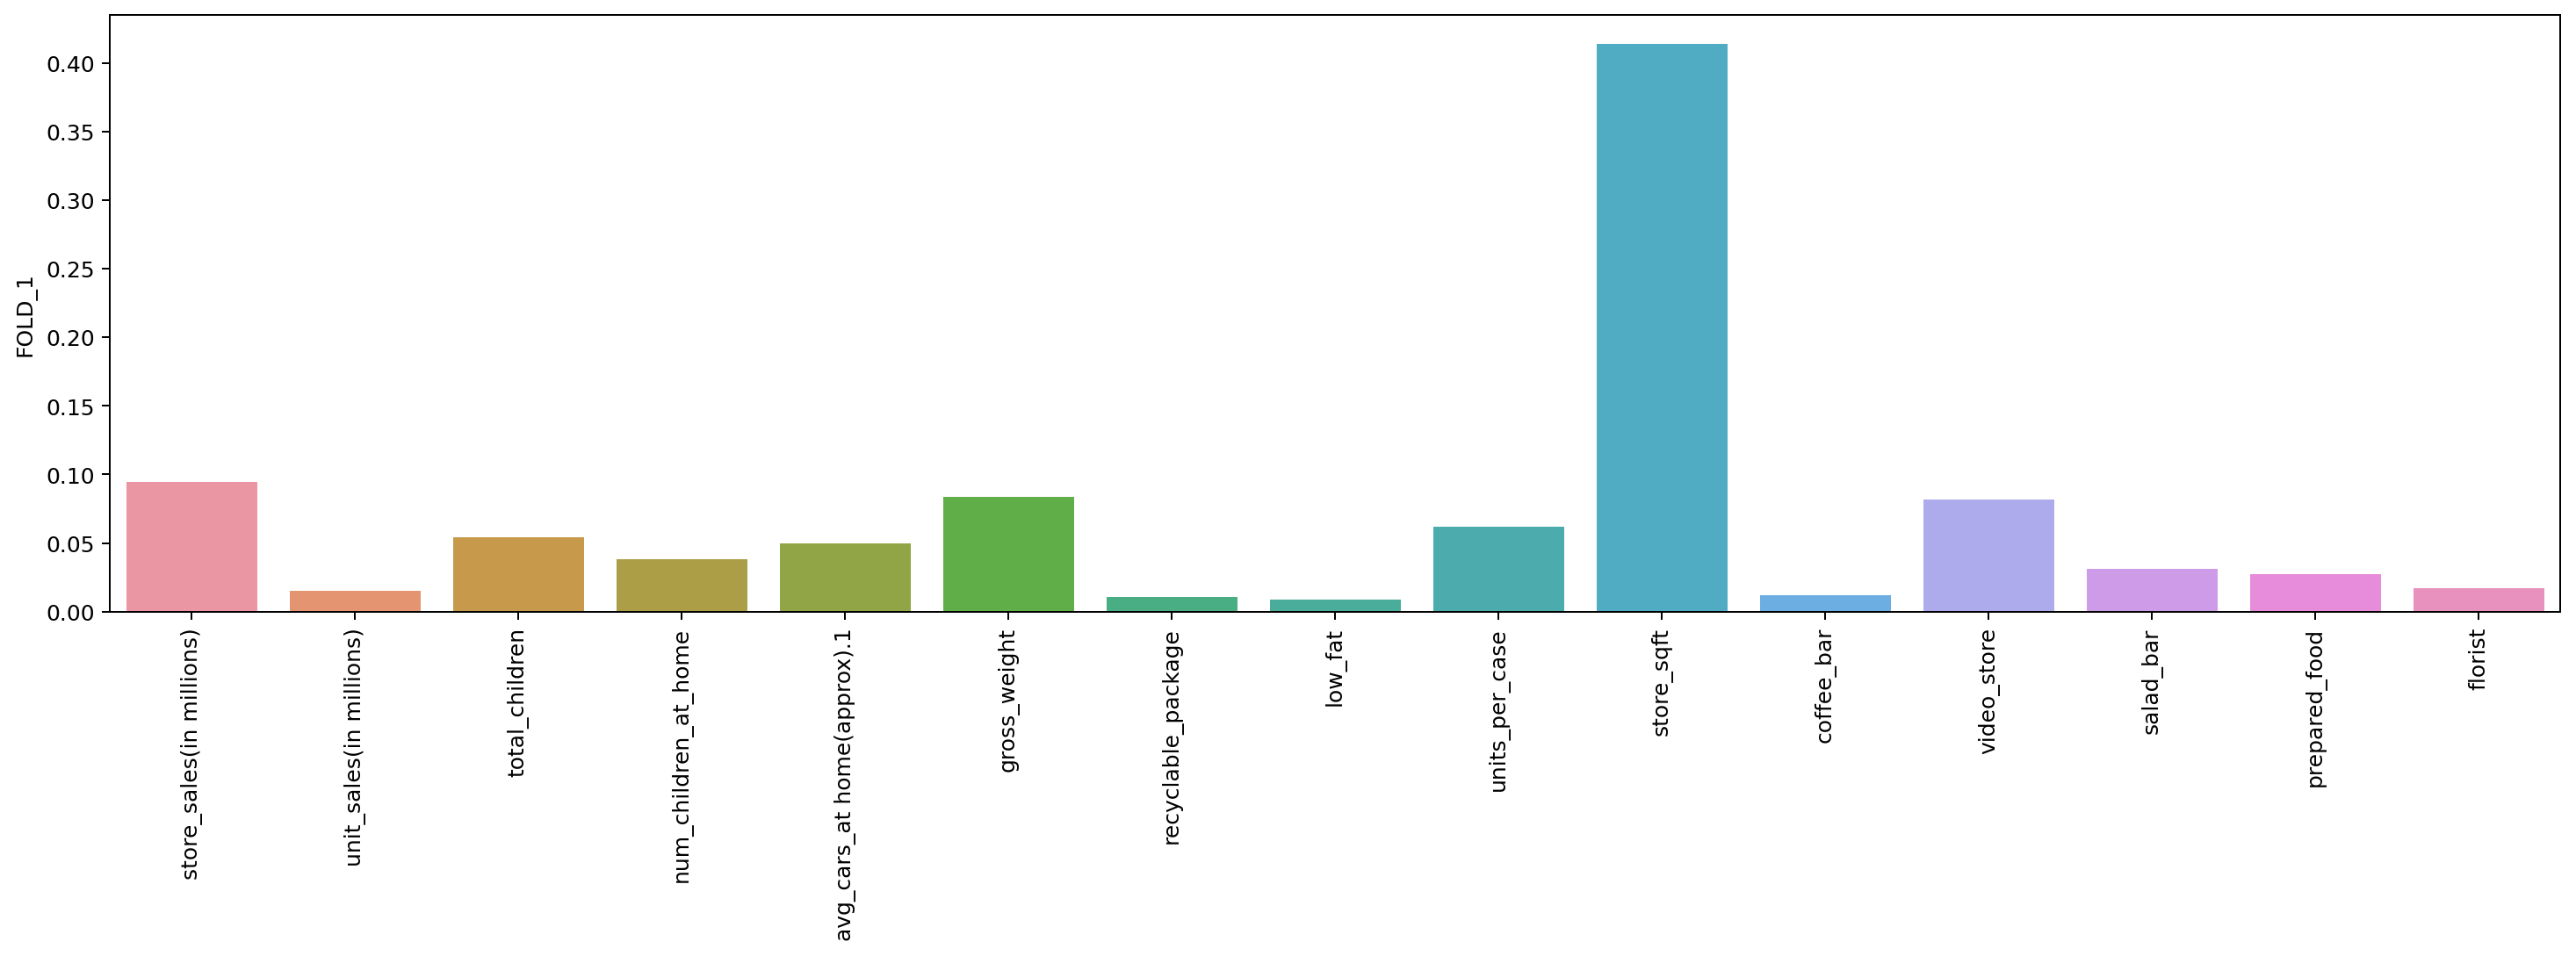

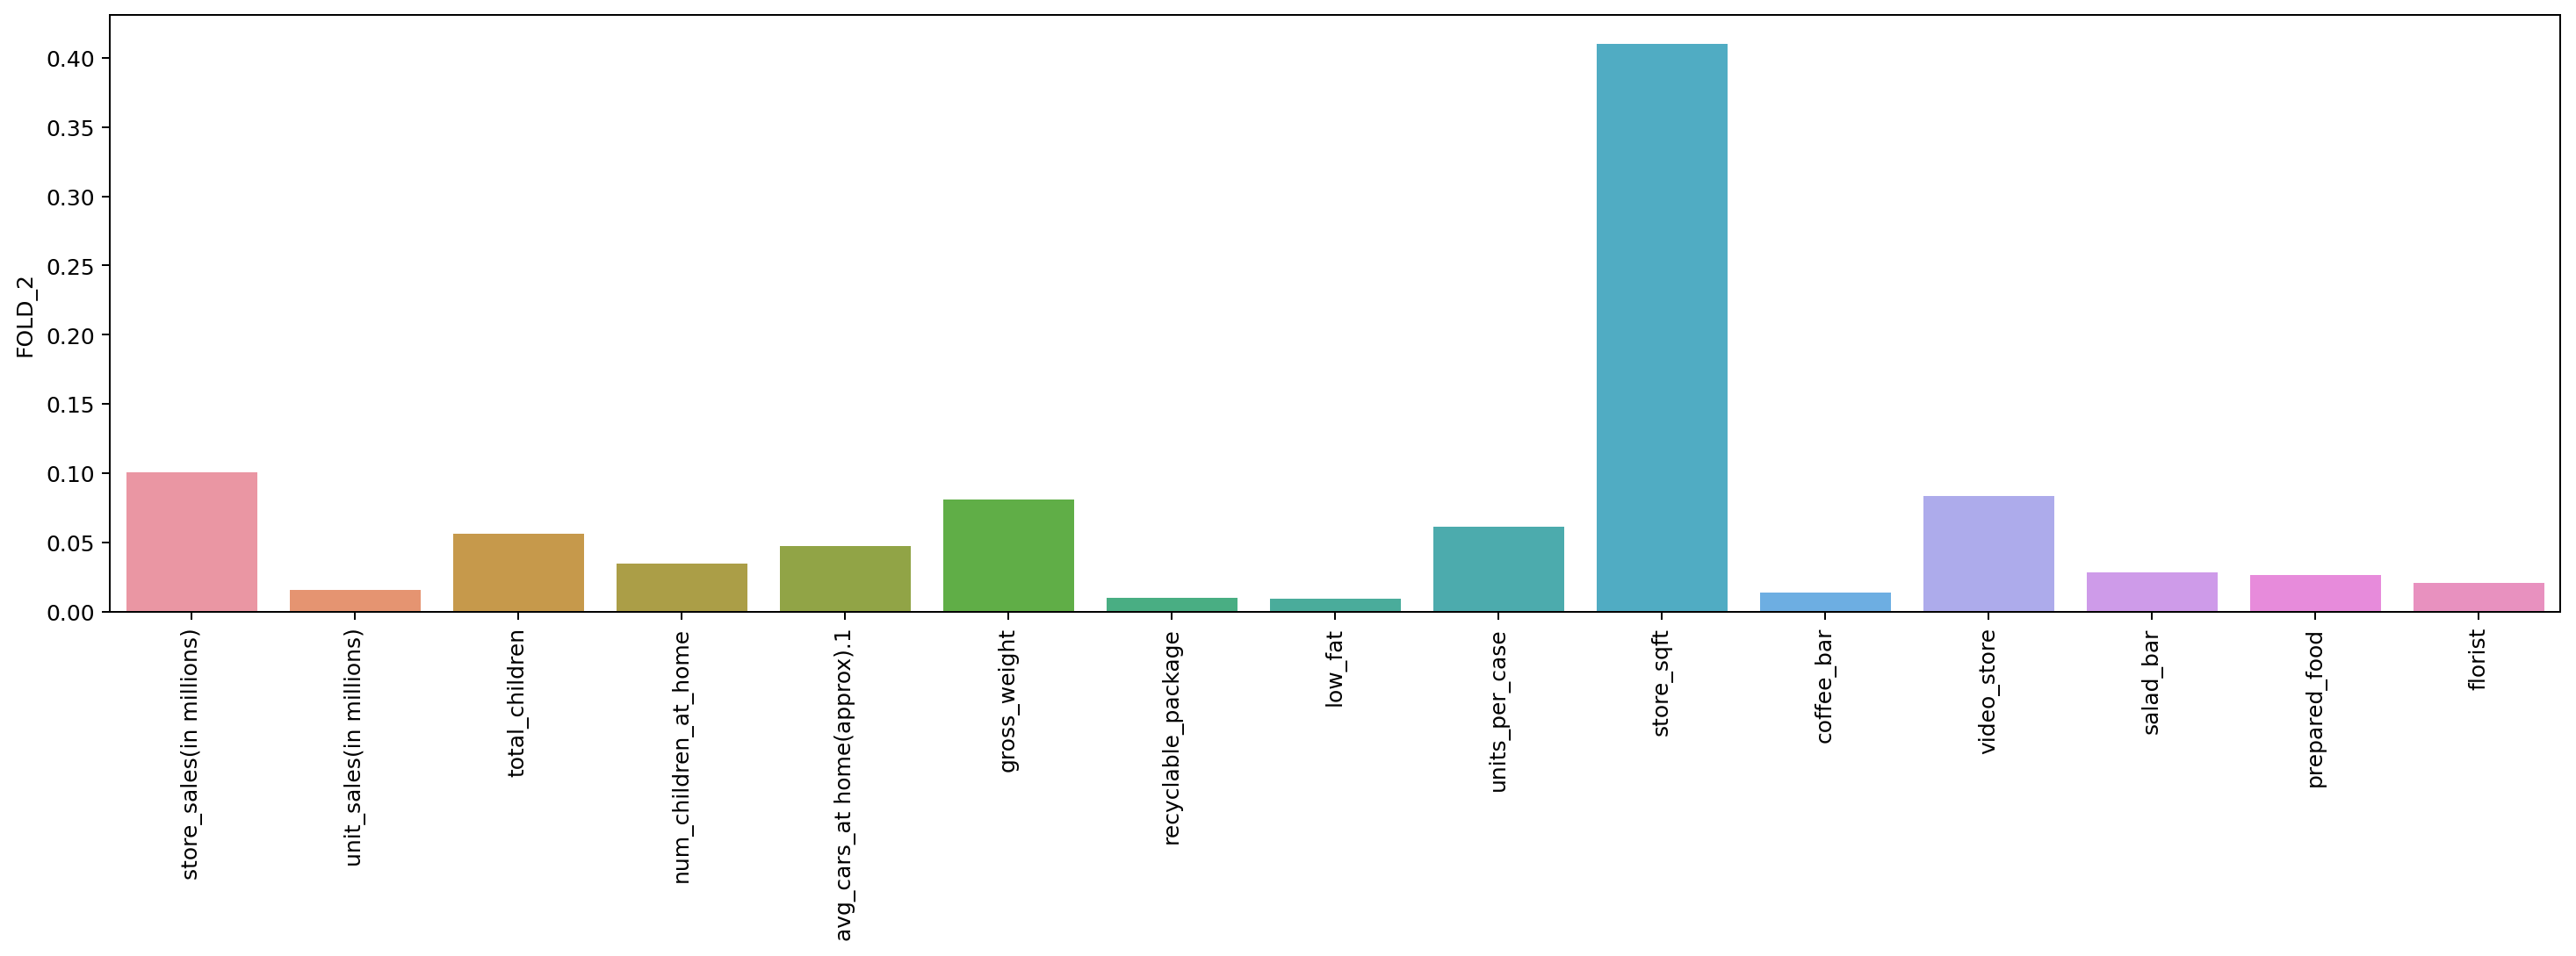

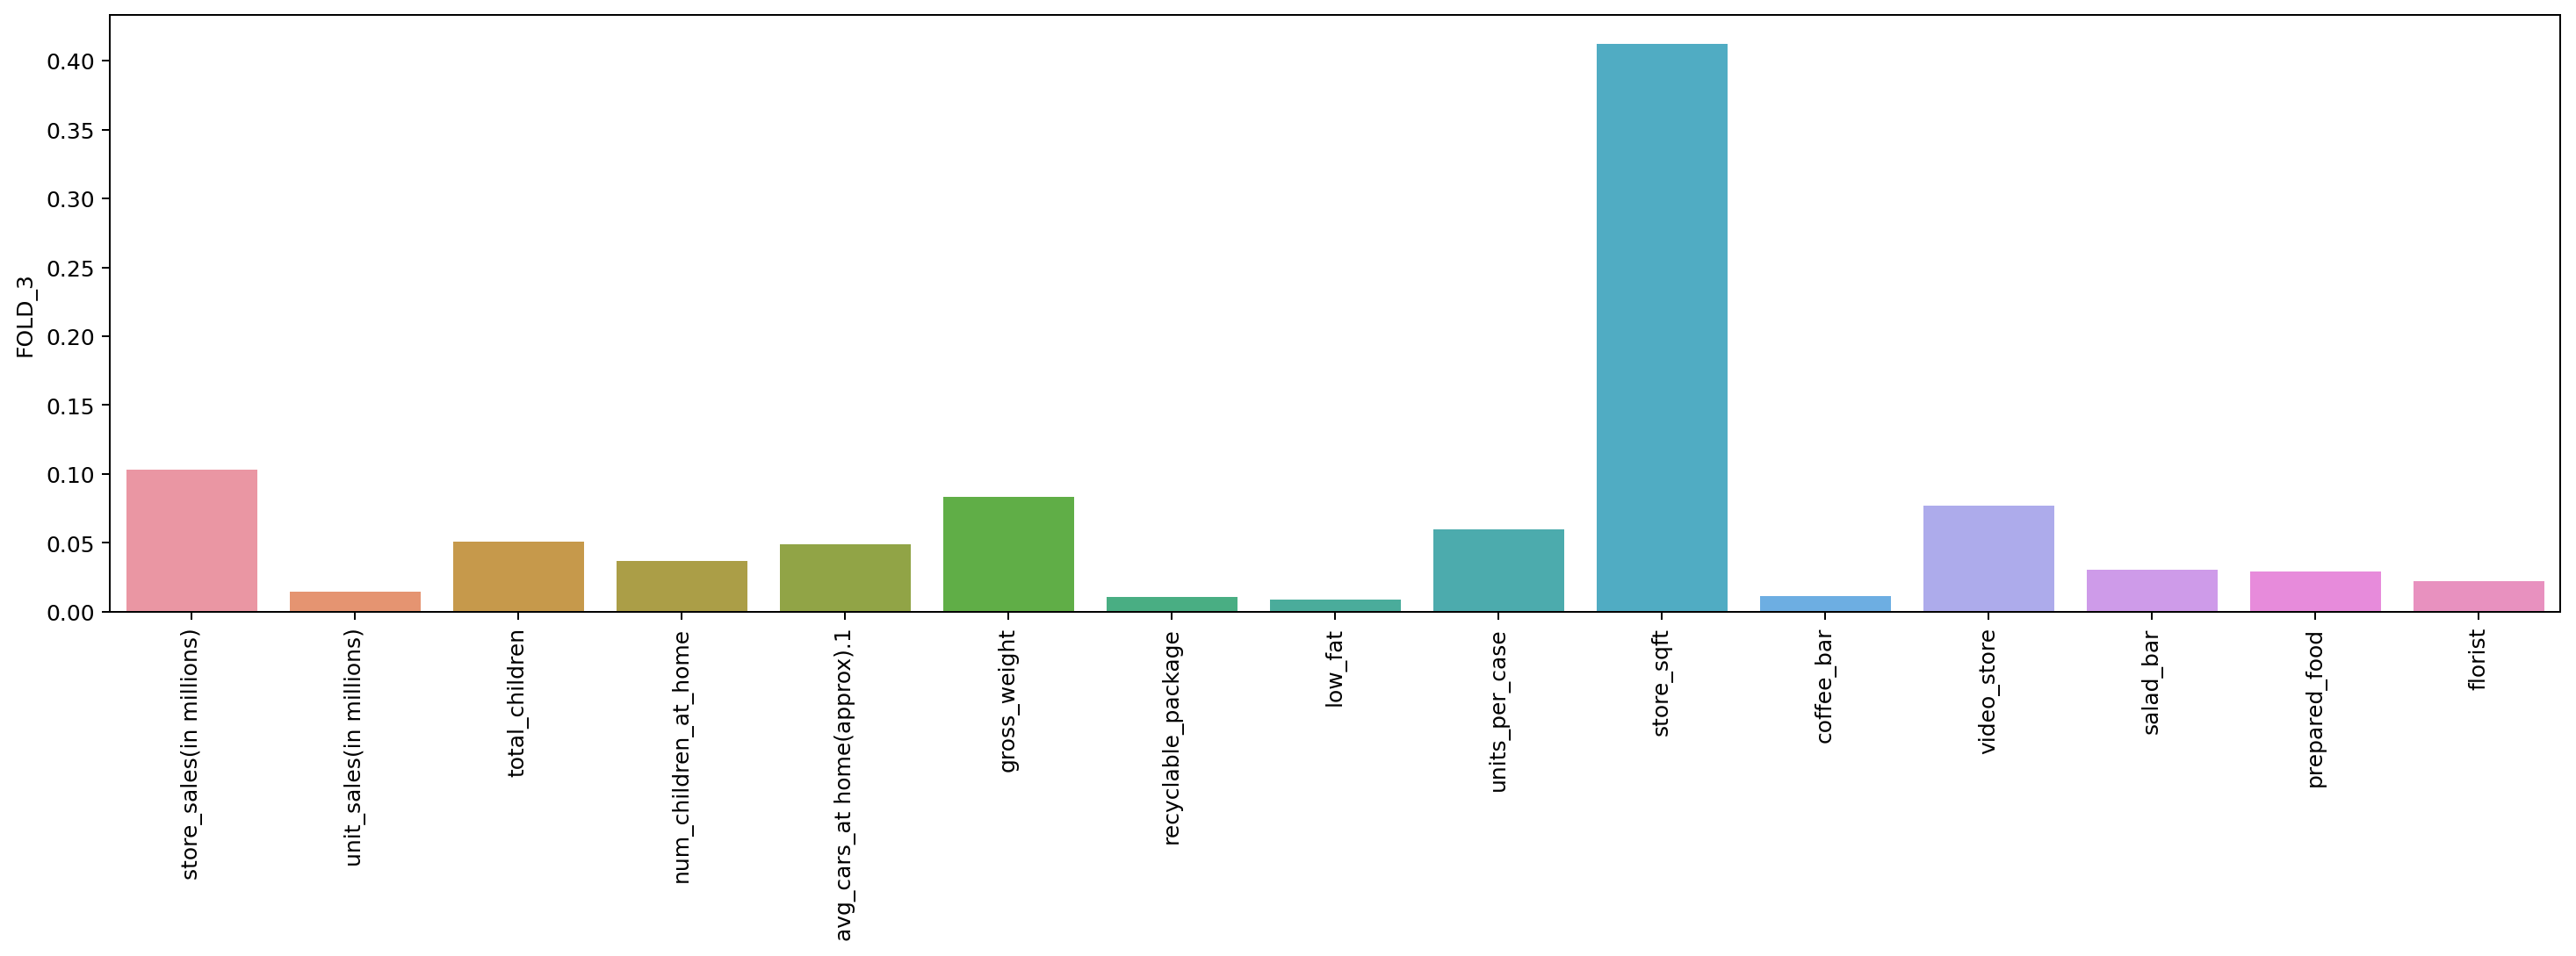

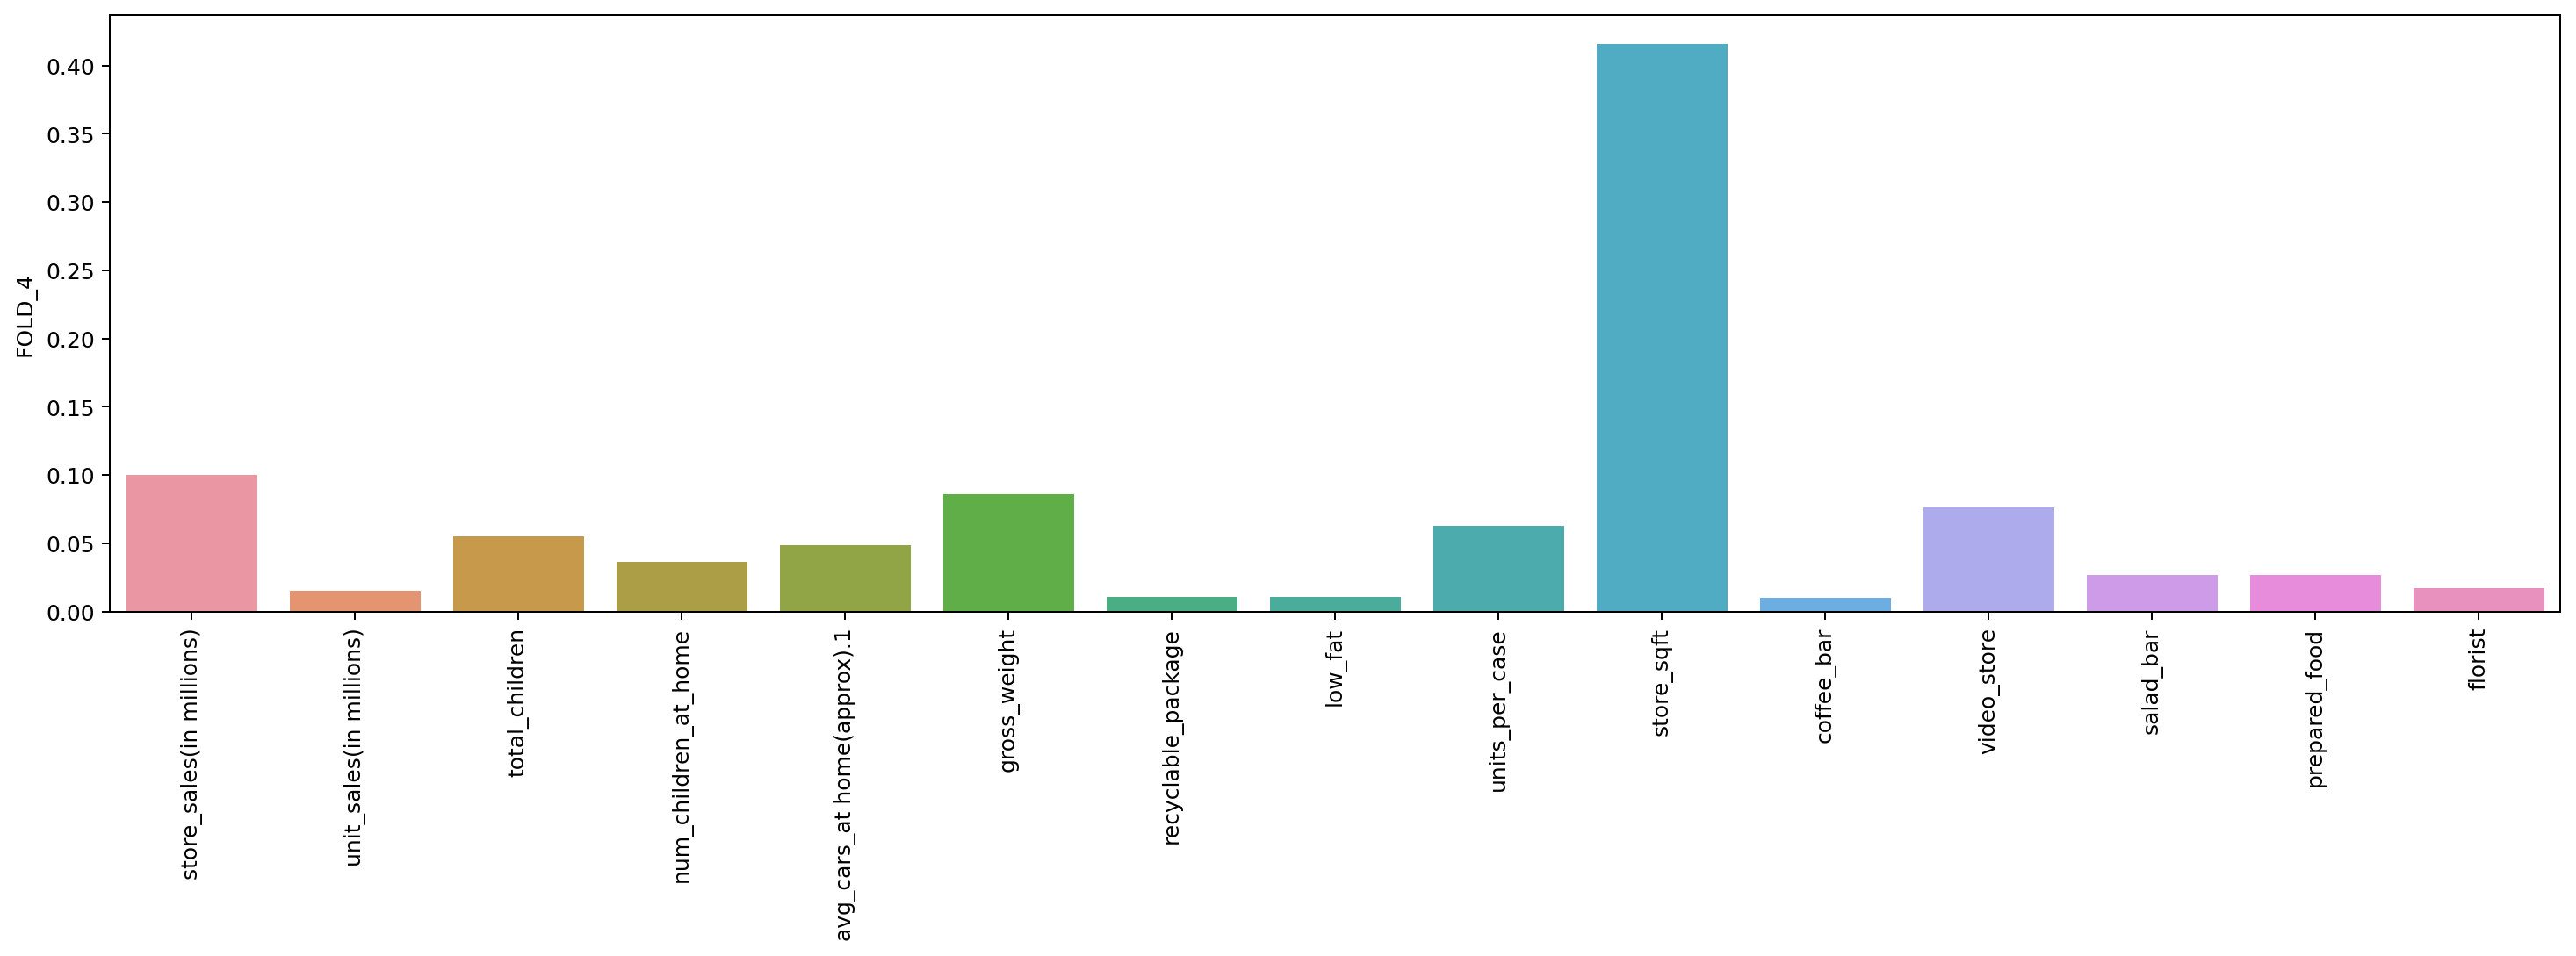

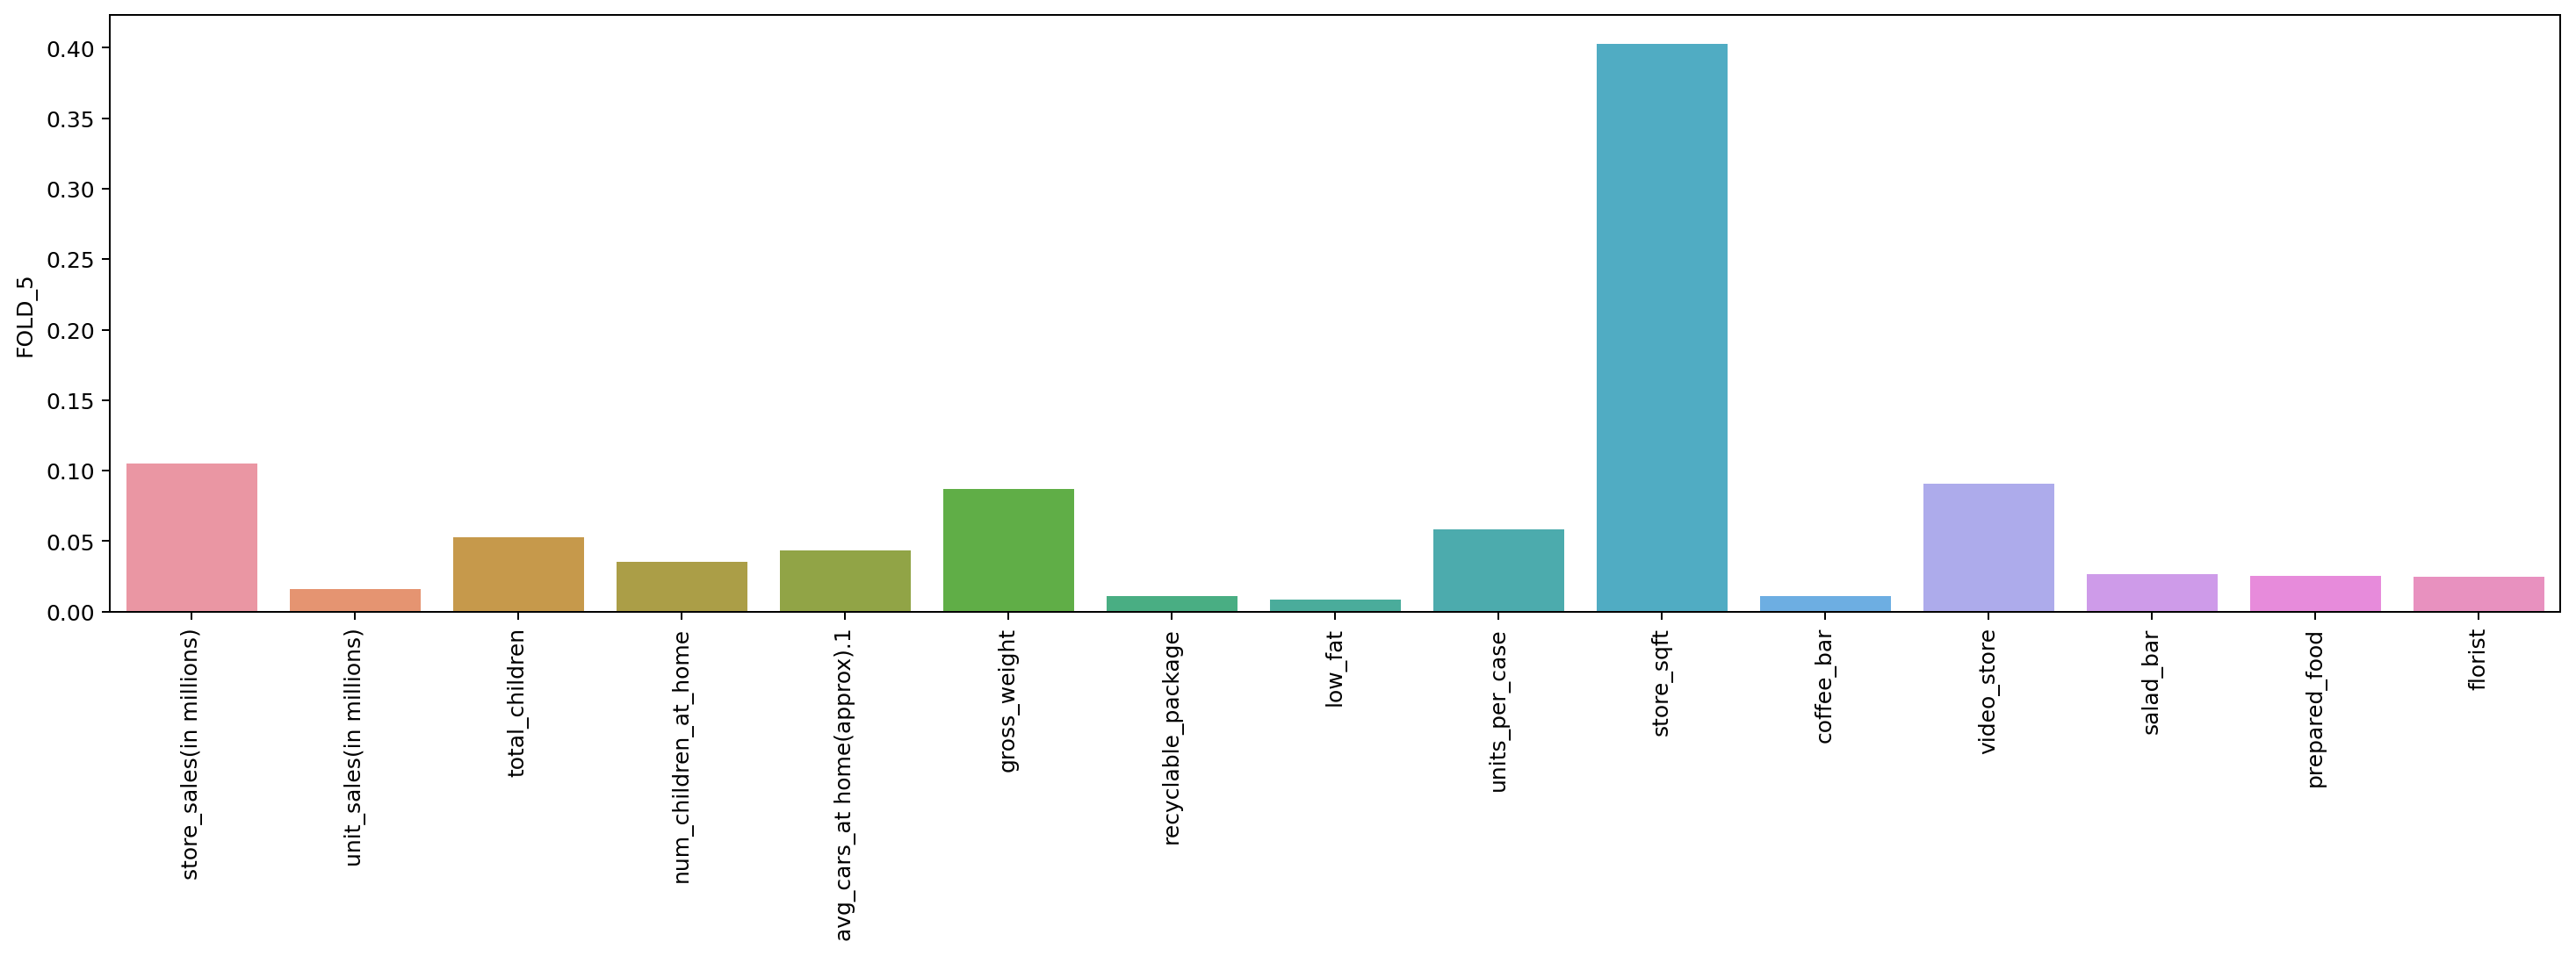

In [25]:
for col in df_importance.columns:
  fig = plt.figure(figsize=(20, 5), dpi=180)
  ax = fig.add_subplot(111)
  sns.barplot(x=df_importance.index, y=df_importance[col], ax=ax)
  plt.xticks(rotation=90)
  plt.show()